# Exact quantum dynamics with the new (PyTorch) TD-SE (SOFT) solver: Multiple states (nonadiabatic dynamics)

## Table of Content <a name="TOC"></a>

1. [Model Hamiltonians](#1)
2. [Setup and run calculations](#3)
3. [Ploting the results](#3)

    3.1. [Plotting the probability density (in k-space) profiles of 1D system](#3.1)
    
    3.2. [Plotting the probability density (in r-space) profiles of 1D system](#3.2)
    
    3.3. [Plotting the adiabatic probability density (in r-space) profiles of 1D system](#3.3)
    
    3.4. [Plotting multiple stored probability density (in r-space) profiles of 1D system](#3.4)

    3.5. [Plotting energy profiles: diabatic](#3.5)

    3.6. [Plotting energy profiles: adiabatic](#3.6)

    3.7. [Kinetic, potential, and total energy as functions of time](#3.7)

    3.8. [Adiabatic and diabatic populations as functions of time](#3.8)

### A. Learning objectives

- to define the model Hamiltonian suitable for the new TDSE solver with multiple states
- to setup and execute a quantum dynamics calculation for 2-level 1DHamiltonian using new exact solver written with PyTorch
- to plot the snapshots of the wavefunction probability density
- to save the results of the new TDSE solver calculations and using them to plot the figures


### B. Use cases

- [Define a model Hamiltonian using PyTorch](#1)
- [Numerically exact solution of the TD-SE](#2)
- [Numerically exact solution of the TD-SE using PyTorch](#2)
- [Snapshots of the dynamics in 1D](#3.1) | [also here](#3.2) | [also here](#3.3) | [also here](#3.4) 
- [Plot the PES components of multistate model Hamiltonians](#3.5) | [also here](#3.6)
- [Plotting evolution of properties from exact dynamics calculations](#3.7) | [also here](#3.8)
- [Save and load the PyTorch tensors to/from file](#3)


### C. Functions

None

### D. Classes and class members

- `libra_py`
  - `dynamics`
    - `exact_torch`
      - `compute`
        - [`tully_potential_matrix`](#1)
        - [`exact_tdse_solver_multistate`](#4)


In [1]:
import torch
import torch.fft
import libra_py.dynamics.exact_torch.compute as compute
import matplotlib.pyplot as plt

plt.rc('axes', titlesize=24)      # fontsize of the axes title
plt.rc('axes', labelsize=24)      # fontsize of the x and y labels
plt.rc('legend', fontsize=24)     # legend fontsize
plt.rc('xtick', labelsize=24)    # fontsize of the tick labels
plt.rc('ytick', labelsize=24)    # fontsize of the tick labels

plt.rc('figure.subplot', left=0.2)
plt.rc('figure.subplot', right=0.95)
plt.rc('figure.subplot', bottom=0.13)
plt.rc('figure.subplot', top=0.88)

## 1. Model Hamiltonians
<a name="1"></a>[Back to TOC](#TOC)

Functions defining the model Hamiltonian matrices (in diabatic representation) suitable for the new solver should be written like this.

Note few things:

* the nuclear coordinates (dofs) are stored in the first dimension of the input tensor `Q`; the
  rest of the dimensions correspond to indices of the multidimensional grid points

* the state dimensions are the last two dimensions of the returned tensors, this is needed to simplify matrix operations
  the preceeding dimensions of the resulting tensor correspond to the shape of the multidimensional grid of the input
  tensor `Q`

* it is important to return the Hamiltonian tensor using the ellips notation `...` so that the "Hamiltonian matrix" is placed correctly 


In [2]:
# Define Tully's simple avoided crossing diabatic potential matrix
def tully_potential_matrix(Q, params):
    """
    Q: Tensor with shape [ndof, Ngrid]
    Returns diabatic potential matrix [2, 2, Ngrid]
    """
    x = Q[0]  # Assume 1D nuclear coordinate

    A = params.get("A", 0.01)
    B = params.get("B", 1.6)
    C = params.get("C", 0.005)
    D = params.get("D", 1.0)


    # Diabatic state 1 potential
    V11 = torch.where(
    x >= 0,
    A * (1 - torch.exp(-B * x)),
    -A * (1 - torch.exp(B * x))
    )
    V22 = -V11                         # Diabatic state 2 potential (mirror)
    V12 = C * torch.exp(-D * x**2)    # Coupling between diabatic states

    shape = x.shape
    Vmat = torch.zeros((*shape, 2, 2), dtype=torch.cfloat)
    Vmat[..., 0, 0] = V11
    Vmat[..., 1, 1] = V22
    Vmat[..., 0, 1] = V12
    Vmat[..., 1, 0] = torch.conj(V12)

    return Vmat

This same function is also defined in the `compute` module:

In [3]:
help(compute.tully_potential_matrix)

Help on function tully_potential_matrix in module libra_py.dynamics.exact_torch.compute:

tully_potential_matrix(Q, params)
    Q: Tensor with shape [ndof, Ngrid]
    Returns diabatic potential matrix [2, 2, Ngrid]



## 2. Setup and run calculations

<a name="2"></a>[Back to TOC](#TOC)

The parameters are pretty much the same as for the adiabatic solver. New ones are:

* `representation` - selects the representation of the initial wavefunction (could be `diabatic` or `adiabatic`)
  
* `initial_state_index` - index of the electronic surface on which to initialize the wavefunction (so far one can
   initialize it on a single state)

* `Nstates` - how many electronic states to consider in the calculations. Should match the dimensionality of the Hamiltonian
   matrices returned by the function set by the `potential_fn` parameter

* `method` - selects the integrator. So far, only `split-operator` option is available  

In [4]:
# Set up parameters
params = {
    "prefix": "tully_avoided_crossing",
    "grid_size": [512],       # 1D grid
    "q_min": [-20.0],
    "q_max": [20.0],
    "save_every_n_steps": 10,
    "dt": 10.0,
    "nsteps": 150,
    "mass": [2000.0],         # realistic nuclear mass unit

    "Nstates": 2,
    "representation": "adiabatic",
    "initial_state_index": 0,   # Start in diabatic state 0
    
    "potential_fn": compute.tully_potential_matrix,
    "potential_fn_params": {
        "A": 0.01,
        "B": 1.6,
        "C": 0.005,
        "D": 1.0
    },
    "psi0_fn" : compute.gaussian_wavepacket,
    "psi0_fn_params": {
        "mass": [2000.0],
        "omega": [0.004],
        "q0": [-6.0],            # initial position left of crossing
        "p0": [20.0]             # initial momentum toward crossing
    },
    "method": "split-operator"
}

The solver can be prepared and executed in the following way:

In [5]:
# Instantiate solver
solver = compute.exact_tdse_solver_multistate(params)

# Initialize grids and wavefunction
solver.initialize_grids()

# Initialize operators
solver.initialize_operators()

# Run the time propagation
solver.propagate()

# Save results to file
solver.save()

print("Simulation completed and data saved.")

Initializing grids
grid_size =  tensor([512])
self.ngrid =  512
Q =  torch.Size([1, 512])
dq =  tensor([0.0783])
K =  torch.Size([1, 512])
dk =  tensor([0.1568])
dV =  tensor(0.0783)
dVk =  tensor(0.1568)
T.shape =  torch.Size([512])
expT.shape =  torch.Size([512])
V.shape =  torch.Size([512, 2, 2])
expV_half.shape =  torch.Size([512, 2, 2])
Step 0: Norm = 1.0000
Step 10: Norm = 1.0000
Step 20: Norm = 1.0000
Step 30: Norm = 1.0000
Step 40: Norm = 1.0000
Step 50: Norm = 1.0000
Step 60: Norm = 1.0000
Step 70: Norm = 1.0000
Step 80: Norm = 1.0000
Step 90: Norm = 1.0000
Step 100: Norm = 1.0000


/home/alexvakimov/SOFTWARE/libra/_build/src/libra_py/dynamics/exact_torch/compute.py:484: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /pytorch/aten/src/ATen/native/Copy.cpp:308.)
  self.total_energy[istep] = KE + PE


Step 110: Norm = 1.0000
Step 120: Norm = 1.0000
Step 130: Norm = 1.0000
Step 140: Norm = 1.0000
Simulation completed and data saved.


The functions are as:

In [6]:
help(compute.exact_tdse_solver_multistate)

Help on class exact_tdse_solver_multistate in module libra_py.dynamics.exact_torch.compute:

class exact_tdse_solver_multistate(builtins.object)
 |  exact_tdse_solver_multistate(params)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, params)
 |      Initializes the TDSE solver.
 |      
 |      Parameters:
 |          params (dict): Dictionary of simulation parameters:
 |              - prefix (str): Filename prefix for output
 |              - grid_size (list[int]): Number of points per spatial dimension
 |              - q_min (list[float]), q_max (list[float]): Spatial bounds
 |              - save_every_n_steps (int): Interval for recording data
 |              - dt (float): Time step
 |              - nsteps (int): Number of time steps
 |              - mass (list[float]): Masses per dimension
 |              - potential_fn_params (dict): Parameters for potential energy surface
 |              - psi0_fn_params (dict): Parameters for initial wavepacket
 |              - devi

Or in a simplified way:

In [7]:
# Instantiate solver
solver = compute.exact_tdse_solver_multistate(params)
solver.solve()

Initializing grids
grid_size =  tensor([512])
self.ngrid =  512
Q =  torch.Size([1, 512])
dq =  tensor([0.0783])
K =  torch.Size([1, 512])
dk =  tensor([0.1568])
dV =  tensor(0.0783)
dVk =  tensor(0.1568)
T.shape =  torch.Size([512])
expT.shape =  torch.Size([512])
V.shape =  torch.Size([512, 2, 2])
expV_half.shape =  torch.Size([512, 2, 2])
Step 0: Norm = 1.0000
Step 10: Norm = 1.0000
Step 20: Norm = 1.0000
Step 30: Norm = 1.0000
Step 40: Norm = 1.0000
Step 50: Norm = 1.0000
Step 60: Norm = 1.0000
Step 70: Norm = 1.0000
Step 80: Norm = 1.0000
Step 90: Norm = 1.0000
Step 100: Norm = 1.0000
Step 110: Norm = 1.0000
Step 120: Norm = 1.0000
Step 130: Norm = 1.0000
Step 140: Norm = 1.0000


## 3. Plotting the results
<a name="3"></a>[Back to TOC](#TOC)

This tutorial comes with pre-computed results stored in the files in the `references` folder. 

To access them, we need to load the objects via `torch.load("name-of-the-file")`. The resulting object will have the 
following properties:

**same as in the single-state solver**

* `grid_size`, `q_min`, `q_max`, `dt`, `nsteps`, `save_every_n_steps`, `mass` - see above
* `ndim` - the dimensionality of the problem
* `time` - the time values for the saved wavefunction snapshots
* `Q` - coordinate grid
* `K` - momentum grid
* `dq` - coordinate grid spacings
* `dk` - momentum grid spacings
* `dV` - volume element in the coordinate space
* `dVk` - volume element in the momentum space
* `kinetic_energy` - kinetic energy stored every `save_every_n_steps` steps
* `potential_energy` - potential energy stored every `save_every_n_steps` steps
* `total_energy` - total energy stored every `save_every_n_steps` steps
* `norm` - current norm
* `V` - diabatic Hamiltonian (potential) on the grid
* `T` - kinetic energy on the grid

**multistate-specific properties**

* `psi_r_adi` - current adiabatic wavefunction on the grid in position representation
* `psi_r_dia` - current diabatic wavefunction on the grid in position representation
* `psi_k_adi` - current adiabatic wavefunction on the grid in momentum representation
* `psi_k_dia` - current diabatic wavefunction on the grid in momentum representation
* `rho_dia_all` - all (stored every `save_every_n_steps` steps) diabatic density matrices in position representation
* `rho_aia_all` - all (stored every `save_every_n_steps` steps) adiabatic density matrices in position representation
* `psi_r_dia_all` - all (stored every `save_every_n_steps` steps) diabatic wavefunctions in position representation
* `psi_r_adi_all` - all (stored every `save_every_n_steps` steps) adiabatic wavefunctions in position representation
* `psi_k_dia_all` - all (stored every `save_every_n_steps` steps) diabatic wavefunctions in momentum representation
* `psi_k_adi_all` - all (stored every `save_every_n_steps` steps) adiabatic wavefunctions in momentum representation
* `E` - the eigenvalues (adiabatic energies) for all the grid points
* `U` - diabatic-to-adiabatic transformation matrices for all the grid points

These properties can be accessed directly from the `solver` object or from the dictionary after e.g.:

```
f = torch.load("references/tully_avoided_crossing.pt")
```

### 3.1. Plotting the probability density (in k-space) profiles of 1D system
<a name="3.1"></a>[Back to TOC](#TOC)

In this example, we:

* read the diabatic wavefunction in k-space (the latest one stored in the solver)

* use the `einsum` to compute the density matrix: $\rho_{ij} = \psi_i \psi_j^*$

* the diagonal elements of the density matrix are the populations densities for
  each state, we plot them in different colors

* finally, we compute the total population on each state and check the normalization
  of the wavefunction - note, we need to add up populations on all states to make up 1.0

torch.Size([512, 2])
torch.Size([512, 2, 2])


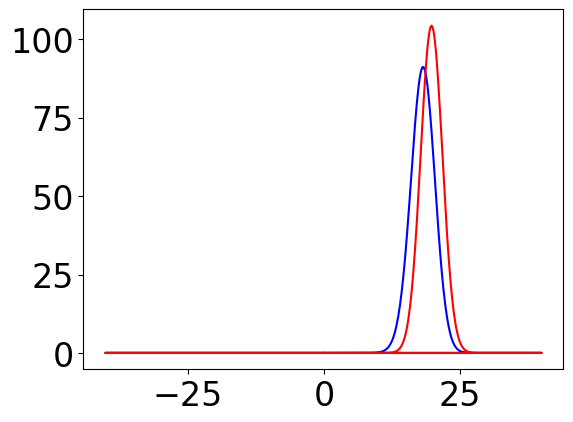

tensor(0.4900+0.j) tensor(0.5100+0.j) tensor(1.0000+0.j)


In [8]:
# for the current (last) state
f = torch.load("references/tully_avoided_crossing.pt")
psi = f["psi_k_dia"] 
print(psi.shape)

rho = torch.einsum("...i, ...j -> ...ij", psi, psi.conj() )
print(rho.shape)
plt.plot(f["K"][0], rho[:, 0,0].real, color="blue")  
plt.plot(f["K"][0], rho[:, 1,1].real, color="red")  
plt.show()

# Total populations
P0 = torch.sum(rho[:, 0, 0]) * (f["dq"]/f["grid_size"]).prod()  
P1 = torch.sum(rho[:, 1, 1]) * (f["dq"]/f["grid_size"]).prod()  
print(P0, P1, P0+P1)

### 3.2. Plotting the probability density (in r-space) profiles of 1D system
<a name="3.2"></a>[Back to TOC](#TOC)

Now repeat all the same but using the r-space wavefunctions:

torch.Size([512, 2])
torch.Size([512, 2, 2])


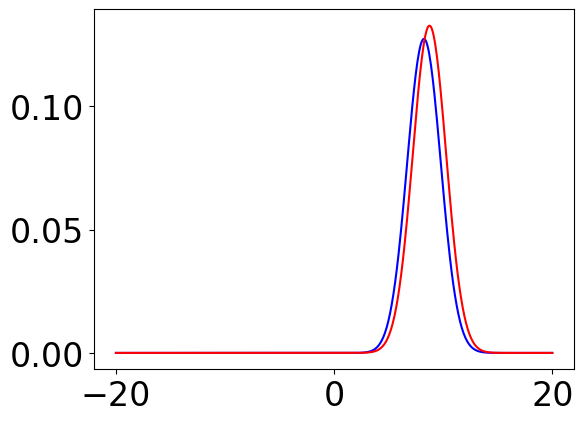

tensor(0.4900-5.7416e-10j) tensor(0.5100+5.6792e-11j) tensor(1.0000-5.1737e-10j)


In [9]:
# for the current (last) state
f = torch.load("references/tully_avoided_crossing.pt")
psi = f["psi_r_dia"] 
print(psi.shape)

rho = torch.einsum("...i, ...j -> ...ij", psi, psi.conj() )
print(rho.shape)
plt.plot(f["Q"][0], rho[:, 0,0].real, color="blue") 
plt.plot(f["Q"][0], rho[:, 1,1].real, color="red")  
plt.show()

# Total populations
P0 = torch.sum(rho[:, 0, 0]) * f["dq"].prod()  
P1 = torch.sum(rho[:, 1, 1]) * f["dq"].prod()  
print(P0, P1, P0+P1)

### 3.3. Plotting the adiabatic probability density (in r-space) profiles of 1D system
<a name="3.3"></a>[Back to TOC](#TOC)

Finally, let's do the r-space profiles, but using the adiabatic wavefunctions

torch.Size([512, 2])
torch.Size([512, 2, 2])


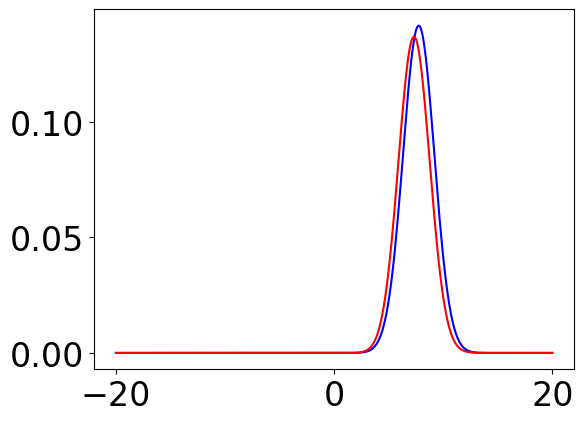

tensor(0.5100-4.5166e-10j) tensor(0.4900-1.4975e-10j) tensor(1.0000-6.0141e-10j)


In [10]:
# for the current (last) state
f = torch.load("references/tully_avoided_crossing.pt")
psi = f["psi_r_adi"] 
print(psi.shape)

rho = torch.einsum("...i, ...j -> ...ij", psi, psi.conj() )
print(rho.shape)
plt.plot(f["Q"][0], rho[:, 0,0].real, color="blue") 
plt.plot(f["Q"][0], rho[:, 1,1].real, color="red")  
plt.show()

# Total populations
P0 = torch.sum(rho[:, 0, 0]) * f["dq"].prod()  
P1 = torch.sum(rho[:, 1, 1]) * f["dq"].prod()  
print(P0, P1, P0+P1)

### 3.4. Plotting multiple stored probability density (in r-space) profiles of 1D system
<a name="3.4"></a>[Back to TOC](#TOC)

For instance, let's plot the probability densities for the 15 saved snapshots using different colors for each state

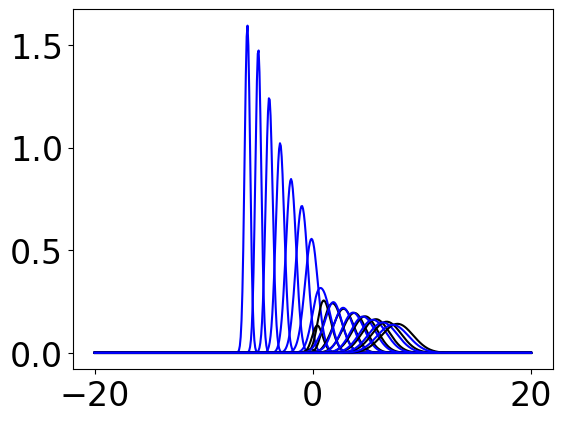

In [11]:
for i in range(15):
    plt.plot(solver.Q[0, :], torch.abs(solver.psi_r_dia_all[i, :, 1])**2, color="black")
    plt.plot(solver.Q[0, :], torch.abs(solver.psi_r_dia_all[i, :, 0])**2, color="blue")

### 3.5. Plotting energy profiles: diabatic 
<a name="3.5"></a>[Back to TOC](#TOC)

First, let's plot the diabatic couplings and energies

/home/alexvakimov/SOFTWARE/Conda/lib/python3.9/site-packages/torch/_tensor.py:1196: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


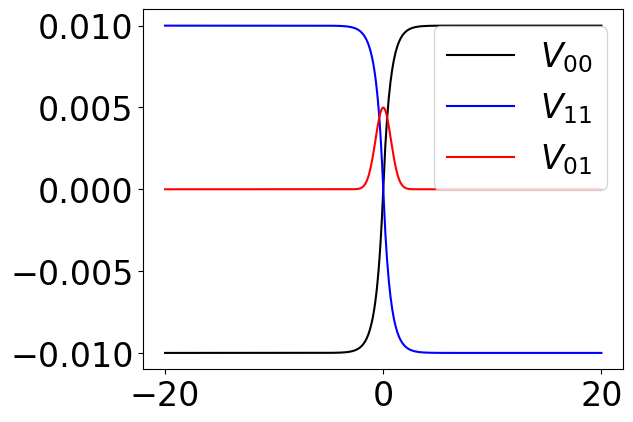

In [12]:
f = torch.load("references/tully_avoided_crossing.pt")
Q = f["Q"]
plt.plot(solver.Q[0, :], f["V"][:, 0, 0], color="black", label = "$V_{00}$")
plt.plot(solver.Q[0, :], f["V"][:, 1, 1], color="blue", label = "$V_{11}$")
plt.plot(solver.Q[0, :], f["V"][:, 0, 1], color="red", label = "$V_{01}$")
plt.legend()
plt.show()

### 3.6. Plotting energy profiles: adiabatic
<a name="3.6"></a>[Back to TOC](#TOC)

Now, let's do the adiabatic profiles

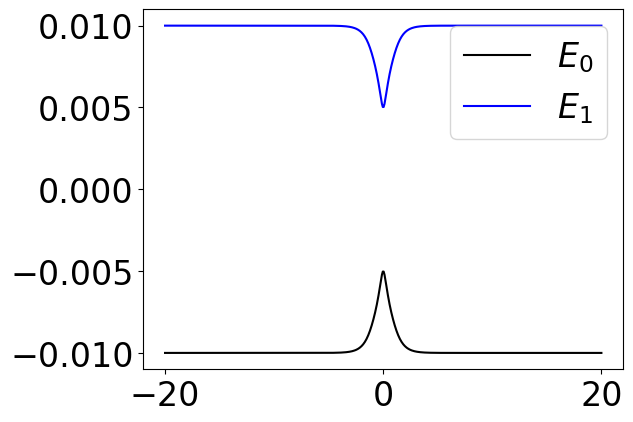

In [13]:
f = torch.load("references/tully_avoided_crossing.pt")
Q = f["Q"]
plt.plot(solver.Q[0, :], f["E"][:, 0], color="black", label = "$E_{0}$")
plt.plot(solver.Q[0, :], f["E"][:, 1], color="blue", label = "$E_{1}$")
plt.legend()
plt.show()

### 3.7. Kinetic, potential, and total energy as functions of time
<a name="3.7"></a>[Back to TOC](#TOC)

/home/alexvakimov/SOFTWARE/Conda/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/alexvakimov/SOFTWARE/Conda/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


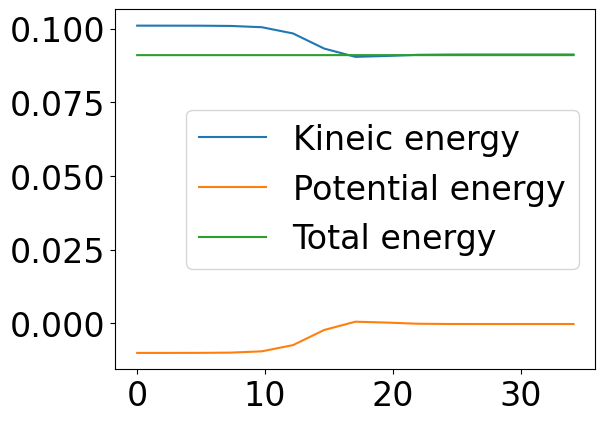

In [14]:
f = torch.load("references/tully_avoided_crossing.pt")
t = torch.tensor(f["time"])/41.0  # to convert to fs
ekin = torch.tensor(f["kinetic_energy"])
epot = f["potential_energy"]
etot = f["total_energy"]

plt.plot(t, ekin, label="Kineic energy")
plt.plot(t, epot, label="Potential energy")
plt.plot(t, etot, label="Total energy")
plt.legend()
plt.show()

### 3.8. Adiabatic and diabatic populations as functions of time
<a name="3.8"></a>[Back to TOC](#TOC)

/tmp/ipykernel_295528/2533278966.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(f["time"])/41.0  # to convert to fs
/tmp/ipykernel_295528/2533278966.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rho_dia = torch.tensor(f["rho_dia_all"])
/tmp/ipykernel_295528/2533278966.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rho_adi = torch.tensor(f["rho_adi_all"])


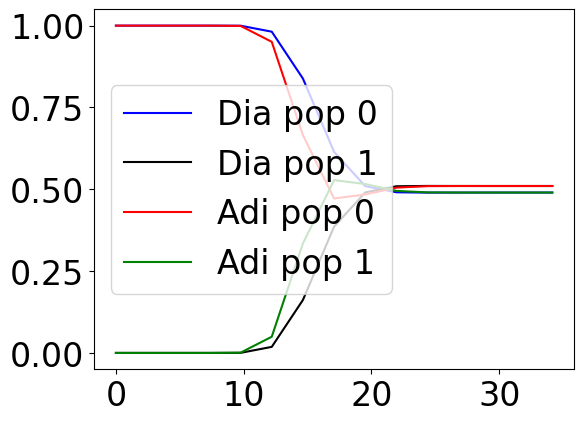

In [15]:
f = torch.load("tully_avoided_crossing.pt")
t = torch.tensor(f["time"])/41.0  # to convert to fs
rho_dia = torch.tensor(f["rho_dia_all"])
rho_adi = torch.tensor(f["rho_adi_all"])

plt.plot(t[:], rho_dia[:,0,0], label="Dia pop 0", color="blue")
plt.plot(t[:], rho_dia[:,1,1], label="Dia pop 1", color="black")

plt.plot(t[:], rho_adi[:,0,0], label="Adi pop 0", color="red")
plt.plot(t[:], rho_adi[:,1,1], label="Adi pop 1", color="green")

plt.legend()
plt.show()